

### **Problem Statement**: Analyzing Social Media Trends
How can social media data be mined to find trending topics and sentiments?

---

####  Approach: Mining Twitter Data for Trending Topics and Sentiment Analysis

To address the problem of analyzing social media trends and extracting sentiment insights, we designed a complete **Twitter Sentiment Analysis Pipeline** using **PySpark** for scalability and efficiency. Here's an overview of the steps involved:

##### 1. **Data Collection & Labeling**

We started with a dataset of tweets, each labeled with one of four sentiment categories:

* **Positive**, **Negative**, **Neutral**, and **Irrelevant**.

##### 2. **Text Preprocessing**

To prepare tweets for analysis, we applied the following cleaning and transformation steps:

* **URL, mentions, and hashtag removal** to eliminate noise.
* **Lowercasing** and **special character filtering** to standardize text.
* **Tokenization** to split tweets into individual words.
* **Stopword removal** to discard common, uninformative words.

##### 3. **Feature Engineering**

We used **CountVectorizer** to convert filtered tokens into numerical feature vectors, capturing the frequency of words across tweets (Bag-of-Words model).

##### 4. **Label Encoding**

We applied `StringIndexer` to convert sentiment labels into numerical indices, making them suitable for machine learning models.

##### 5. **Model Training**

A **Logistic Regression** model was trained on the vectorized features to classify tweets into their respective sentiment categories. The entire process—from tokenization to model training—was encapsulated in a **PySpark ML pipeline**.

##### 6. **Model Persistence & Reusability**

The trained pipeline was saved and later reloaded using `PipelineModel.load()` to support reproducibility and deployment without retraining.

##### 7. **Model Evaluation**

We evaluated model performance using:

* **Accuracy**: Achieved a strong score of **88.1%** on validation data.
* **Confusion Matrix**: Visualized performance across all sentiment classes, highlighting strengths and areas of confusion (e.g., Neutral vs. Negative).

---

####  Outcome

This pipeline demonstrates how social media data—specifically tweets—can be effectively mined and analyzed to understand public sentiment and track trending topics. The approach is scalable and can be adapted for real-time social media monitoring or extended to include topic modeling and trend detection.

---



In [ ]:
# Third-Party Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import nltk
from nltk.corpus import stopwords

# PySpark Core
from pyspark.sql import SparkSession
from pyspark.sql.functions import (col, lower, regexp_replace)

# PySpark ML - Feature Engineering
from pyspark.ml.feature import (
    CountVectorizer, StringIndexer, Tokenizer, StopWordsRemover
)

# PySpark ML - Models
from pyspark.ml.classification import LogisticRegression

# PySpark ML - Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# PySpark ML - Pipeline and Utilities
from pyspark.ml import PipelineModel, Pipeline

# NLTK Downloads
nltk.download('stopwords')
nltk.download('punkt')

# Define English stopwords
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
# Creating a SparkSession
spark = SparkSession.builder \
    .appName("Text Classification with PySpark") \
    .getOrCreate()

In [25]:
# Loading the data
data = spark.read.csv('twitter_training.csv', header=False, inferSchema=True)
validation = spark.read.csv('twitter_validation.csv', header=False, inferSchema=True)

In [26]:
# Define column names
columns = ['id', 'Company', 'Label', 'Text']

# Rename columns
for i, col in enumerate(columns):
    data = data.withColumnRenamed('_c{}'.format(i), col)
    validation = validation.withColumnRenamed('_c{}'.format(i), col)

In [27]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Company: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- Text: string (nullable = true)



In [28]:
# Drop rows with empty 'Text' column
data = data.dropna(subset=['Text'])
validation = validation.dropna(subset=['Text'])

In [29]:
data.select("Text").show(10)

+--------------------+
|                Text|
+--------------------+
|im getting on bor...|
|I am coming to th...|
|im getting on bor...|
|im coming on bord...|
|im getting on bor...|
|im getting into b...|
|So I spent a few ...|
|So I spent a coup...|
|So I spent a few ...|
|So I spent a few ...|
+--------------------+
only showing top 10 rows



To prepare the sentiment labels for machine learning, we use StringIndexer to convert categorical labels (like "Positive", "Negative", etc.) into numerical values. This helps Spark ML models understand and process the labels effectively.

In [30]:
# Define StringIndexer for the label column
label_indexer = StringIndexer(inputCol="Label", outputCol="Label2")

# Fit StringIndexer on data
label_indexer_model = label_indexer.fit(data)
data = label_indexer_model.transform(data)
validation = label_indexer_model.transform(validation)

# Extract label mapping
label_mapping = label_indexer_model.labels

# Print label mapping
print("Label Mapping:")
for index, label in enumerate(label_mapping):
    print(f"Index {index} --> Label '{label}'")

Label Mapping:
Index 0 --> Label 'Negative'
Index 1 --> Label 'Positive'
Index 2 --> Label 'Neutral'
Index 3 --> Label 'Irrelevant'


###  Text Cleaning

Before analyzing tweet sentiment, we clean the raw text to remove noise and improve model performance. The `clean_text` function processes the text data using the following steps:

1. **Remove URLs:** Strips out web links such as `https://...`, `www...`, or YouTube links.
2. **Remove Mentions and Hashtags:** Deletes words starting with `@` (user mentions) or `#` (hashtags).
3. **Convert to Lowercase:** Standardizes all text to lowercase for consistency.
4. **Remove Special Characters:** Keeps only alphabetic characters and spaces—removes numbers, punctuation, emojis, etc.

The cleaned output is stored in a new column called `cleaned_text`.



In [31]:
def clean_text(df, inputCol="Text", outputCol="cleaned_text"):
    df = df.withColumn(outputCol, regexp_replace(df[inputCol], r'https?://\S+|www\.\S+|S+\.com\S+|youtu\.be/\S+', ''))
    df = df.withColumn(outputCol, regexp_replace(df[outputCol], r'(@|#)\w+', ''))
    df = df.withColumn(outputCol, lower(df[outputCol]))
    df = df.withColumn(outputCol, regexp_replace(df[outputCol], r'[^a-zA-Z\s]', ''))

    return df

In [32]:
cleaned_data = clean_text(data, inputCol="Text", outputCol="Text")
cleaned_validation = clean_text(validation, inputCol="Text", outputCol="Text")

###  Text Preprocessing and Modeling Pipeline

This section prepares the cleaned tweet text for machine learning by converting it into numerical features and applying a classification model. The steps include:

1. **Tokenization:**
   Splits the tweet text into individual words (tokens).
   `Tokenizer(inputCol="Text", outputCol="tokens")`

2. **Stop Words Removal:**
   Removes common words (like *"the"*, *"is"*, *"and"*) that carry little meaningful information.
   `StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=stop_words)`

3. **Feature Extraction with CountVectorizer:**
   Converts the filtered tokens into a vector of word counts (bag-of-words model).
   `CountVectorizer(inputCol="filtered_tokens", outputCol="features", vocabSize=10000, minDF=5)`

4. **Logistic Regression Model:**
   A simple and effective classification model is trained to predict sentiment based on the extracted features.
   `LogisticRegression(maxIter=10, labelCol="Label2", featuresCol="features")`

These components together form a complete preprocessing and modeling pipeline for sentiment analysis.



In [33]:
# Tokenizer
tokenizer = Tokenizer(inputCol="Text", outputCol="tokens")

# Stopwords remover
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=stop_words)

# CountVectorizer
count_vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="features", vocabSize=10000, minDF=5)

# Logistic Regression
lr = LogisticRegression(maxIter=10, labelCol="Label2", featuresCol="features")

In [34]:
# Create the pipeline
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, lr])

# Apply the pipeline to the data
model = pipeline.fit(cleaned_data)
processed_data = model.transform(cleaned_data)



### Building and Applying the ML Pipeline

To streamline the preprocessing and modeling steps, we create a **Pipeline**, which allows us to chain multiple data transformation and modeling stages into a single workflow.

1. **Pipeline Creation:**
   Combines the following stages into one reusable process:

   * `Tokenizer`
   * `StopWordsRemover`
   * `CountVectorizer`
   * `LogisticRegression`

   ```python
   pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, lr])
   ```

2. **Fit and Transform:**

   * The pipeline is **fit** on the cleaned dataset to learn from the data.
   * Then it **transforms** the data, applying all stages and generating predictions.

   ```python
   model = pipeline.fit(cleaned_data)
   processed_data = model.transform(cleaned_data)
   ```

This approach ensures that all steps are executed in sequence and keeps the workflow modular, clean, and scalable.

In [35]:
processed_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Company: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- Label2: double (nullable = false)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [36]:
processed_data.select("Text", "Label2", "prediction").show()

+--------------------+------+----------+
|                Text|Label2|prediction|
+--------------------+------+----------+
|im getting on bor...|   1.0|       1.0|
|i am coming to th...|   1.0|       1.0|
|im getting on bor...|   1.0|       1.0|
|im coming on bord...|   1.0|       1.0|
|im getting on bor...|   1.0|       1.0|
|im getting into b...|   1.0|       1.0|
|so i spent a few ...|   1.0|       1.0|
|so i spent a coup...|   1.0|       1.0|
|so i spent a few ...|   1.0|       1.0|
|so i spent a few ...|   1.0|       1.0|
| so i spent a few...|   1.0|       1.0|
|                 was|   1.0|       0.0|
|rockhard la varlo...|   2.0|       2.0|
|rockhard la varlo...|   2.0|       2.0|
|rockhard la varlo...|   2.0|       2.0|
|rockhard la vita ...|   2.0|       2.0|
|live rock  hard m...|   2.0|       2.0|
|ihard like me rar...|   2.0|       2.0|
|that was the firs...|   1.0|       1.0|
|this was the firs...|   1.0|       1.0|
+--------------------+------+----------+
only showing top

In [37]:
model.write().overwrite().save("bigData_logReg_model.pkl")

### Loading a Saved Model

To reuse a previously trained sentiment analysis model without retraining, we load it from disk using `PipelineModel`.


* This loads the entire preprocessing and logistic regression pipeline from the file `bigData_logReg_model.pkl`.
* Once loaded, the model can be used to make predictions on new or unseen tweet data.

In [38]:
from pyspark.ml import PipelineModel

# Load the model
loaded_model = PipelineModel.load("bigData_logReg_model.pkl")

In [39]:
cleaned_validation.show(10)

+-----+--------------------+----------+--------------------+------+
|   id|             Company|     Label|                Text|Label2|
+-----+--------------------+----------+--------------------+------+
| 3364|            Facebook|Irrelevant|i mentioned on fa...|   3.0|
|  352|              Amazon|   Neutral|bbc news  amazon ...|   2.0|
| 8312|           Microsoft|  Negative| why do i pay for...|   0.0|
| 4371|               CS-GO|  Negative|csgo matchmaking ...|   0.0|
| 4433|              Google|   Neutral|now the president...|   2.0|
| 6273|                FIFA|  Negative|hi  ive had madel...|   0.0|
| 7925|           MaddenNFL|  Positive|         thank you  |   1.0|
|11332|TomClancysRainbowSix|  Positive|rocket league sea...|   1.0|
| 1107|      AssassinsCreed|  Positive|my ass still knee...|   1.0|
| 2069|          CallOfDuty|  Negative|fix it jesus  ple...|   0.0|
+-----+--------------------+----------+--------------------+------+
only showing top 10 rows



In [40]:
# Apply  pipeline to the new data
processed_validation = loaded_model.transform(cleaned_validation)

selected_data = processed_validation.select("id", "Text", "prediction", "Label2")

# Show the processed data
selected_data.show()

+-----+--------------------+----------+------+
|   id|                Text|prediction|Label2|
+-----+--------------------+----------+------+
| 3364|i mentioned on fa...|       3.0|   3.0|
|  352|bbc news  amazon ...|       2.0|   2.0|
| 8312| why do i pay for...|       0.0|   0.0|
| 4371|csgo matchmaking ...|       0.0|   0.0|
| 4433|now the president...|       2.0|   2.0|
| 6273|hi  ive had madel...|       0.0|   0.0|
| 7925|         thank you  |       1.0|   1.0|
|11332|rocket league sea...|       1.0|   1.0|
| 1107|my ass still knee...|       1.0|   1.0|
| 2069|fix it jesus  ple...|       0.0|   0.0|
| 3185|the professional ...|       1.0|   1.0|
| 1172|itching to assass...|       1.0|   1.0|
|11783| hey fred comcast...|       0.0|   0.0|
| 4286|csgo wingman im s...|       2.0|   2.0|
| 8431| game sucks down ...|       0.0|   0.0|
| 9135|congrats to the n...|       1.0|   1.0|
| 4822|    yeah and its fun|       1.0|   1.0|
| 3068|       fuck my life |       0.0|   0.0|
|10537|happy 

### Model Evaluation

After training the model, we evaluate its performance using accuracy and a confusion matrix.

1. **Accuracy Evaluation:**
   We use `MulticlassClassificationEvaluator` to compute the **accuracy** of the model on the validation data.


2. **Confusion Matrix:**
   To better understand model performance across each sentiment class, we compute and visualize a **confusion matrix**:




Accuracy: 0.881
Confusion Matrix:


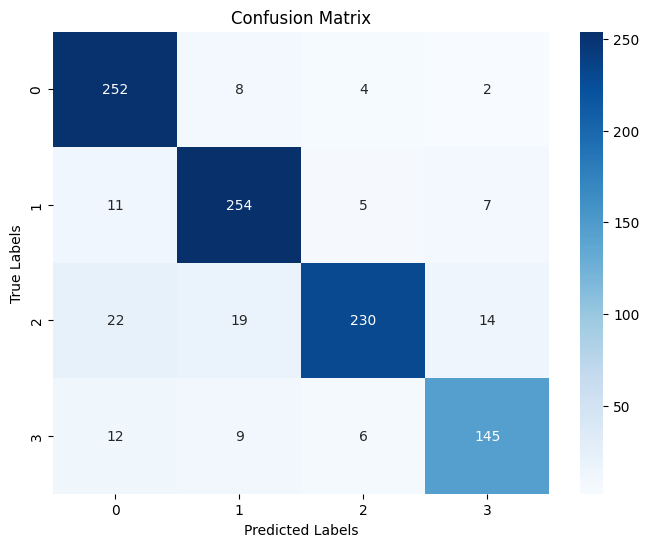

In [41]:
# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Label2", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(processed_validation)
print("Accuracy:", accuracy)

# Convert Spark DataFrame to Pandas DataFrame
prediction_and_label_pd = processed_validation.select("prediction", "Label2").toPandas()

# Extract predicted labels and true labels
predicted_labels = prediction_and_label_pd["prediction"].tolist()
true_labels = prediction_and_label_pd["Label2"].tolist()

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [42]:
# Stop SparkSession
spark.stop()


---

###  Evaluation Results

After applying the trained logistic regression model to the validation dataset, we evaluated its performance using **accuracy** and a **confusion matrix**.

####  **Model Accuracy**

The overall accuracy of the model is:

```text
Accuracy: 0.881
```

This means the model correctly predicted the sentiment of tweets **88.1%** of the time — a strong result for a multi-class classification task.

####  **Confusion Matrix Interpretation**

The confusion matrix below shows the model's performance across four sentiment categories:

| Label Index | Sentiment  |
| ----------- | ---------- |
| 0           | Negative   |
| 1           | Positive   |
| 2           | Neutral    |
| 3           | Irrelevant |

Each cell represents the number of predictions made for each true vs. predicted label combination:

* **Diagonal cells** (e.g., 252, 254, 230, 145) indicate **correct predictions**.
* **Off-diagonal cells** indicate **misclassifications**, such as:

  * 22 Neutral tweets misclassified as Negative.
  * 12 Irrelevant tweets misclassified as Negative.
  * Some Positive tweets mislabeled as Neutral or Irrelevant.

####  Key Observations

* The model performs **very well** in identifying **Positive** and **Negative** sentiments, with very few misclassifications.
* **Neutral** tweets have slightly more overlap with other classes, especially Negative.
* **Irrelevant** tweets show the most confusion, especially with Neutral and Negative, which is common in sentiment analysis due to ambiguous content.

####  Confusion Matrix Heatmap

The heatmap visualizes the classification results. Darker diagonal cells represent stronger model performance in those classes.

---
